In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
from   matplotlib import pyplot as plt, colors

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

from backends import plot as plot, density_model as density_model


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [2]:
#  Inputs config

cWtil_vals      = [0, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]
cWtil_eval_vals = [0, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]

input_fnames = {}
input_fnames [0   ] = "../Data/SM_EWK_1M_rivet_output.pickle"

     #    "../Data/SM_EWK_rivet_output.pickle",   "../Data/SM_EWK_500k_rivet_output.pickle",   "../Data/SM_EWK_1M_rivet_output.pickle"

input_fnames [-0.4] = "../Data/cWtil_m0p4_full_400k_rivet_output.pickle"
input_fnames [-0.3] = "../Data/cWtil_m0p3_full_400k_rivet_output.pickle"
input_fnames [-0.2] = "../Data/cWtil_m0p2_full_400k_rivet_output.pickle"
input_fnames [-0.1] = "../Data/cWtil_m0p1_full_400k_rivet_output.pickle"
input_fnames [ 0.1] = "../Data/cWtil_0p1_full_400k_rivet_output.pickle"
input_fnames [ 0.2] = "../Data/cWtil_0p2_full_400k_rivet_output.pickle"
input_fnames [ 0.3] = "../Data/cWtil_0p3_full_400k_rivet_output.pickle"
input_fnames [ 0.4] = "../Data/cWtil_0p4_full_400k_rivet_output.pickle"


In [31]:
#  Model config

output_size_per_stage     = 20
max_epochs                = 1000
batch_size                = 2000
epoch_increase_per_level  = 0
early_stopping_patience   = 10
early_stopping_min_delta  = 0
validation_split          = 0.5

white_linear_fraction_data  = [0.1, 0.8, 0.8, 0.1]   # [0.2, 0.8, 0.8, 0.7]  # 0.8
white_linear_fraction_gauss = 0.
whitening_num_points        = 200
whitening_func_form         = "step"
whitening_alpha, whitening_beta, whitening_gamma = 4, 3, 1

load_whitening_funcs = None   # ".whitening_funcs.pickle"
save_whitening_funcs = ".whitening_funcs.pickle"   # ".whitening_funcs.pickle"

load_model_dir = None                     # ".EWK_density_model"
save_model_dir = ".EWK_density_model"     # ".EWK_density_model"

learning_rate = 0.001     # 0.01 for SGD or 0.001 otherwise
optimiser     = "adam"     # SGD, Adam or AdaDelta

In [32]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["m_jj", "m_ll", "Dphi_j_j", "Dy_j_j"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


In [5]:
#  Load and format the data
#

data_tables = {}
for cWtil in cWtil_eval_vals :
    input_fname = input_fnames [cWtil]
    print(f"Creating data table for cWtil={cWtil}")
    print(f" -- events from file {input_fname}")
    data = DataTable(input_fname)
    print(f" -- Table created with {data.get_num_events()} events")
    for observable, limits in observable_limits.items() :
        print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
        data.filter(observable, limits[0], limits[1])
        print(f" -- {data.get_num_events()} events survived")
    for observable in remove_observables :
        print(f" -- removing observable {observable}")
        data.remove_column(observable)
    print(" -- ordering observables")
    data.reorder(*observables_order)
    data.print_summary()
    data_tables [cWtil] = data
    

Creating data table for cWtil=0
 -- events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable m_ll between 75 and 105
 -- 660799 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 660766 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 660766 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 652255 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 643177 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 643177 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 643177 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 643177 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 643054 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 642591 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 642591 events s

 -- 257153 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 257153 events survived
 -- removing observable N_jets
 -- removing observable pT_ll
 -- removing observable rap_ll
 -- removing observable theta_ll
 -- removing observable pT_jj
 -- removing observable theta_jj
 -- removing observable rap_jj
 -- removing observable pT_j1
 -- removing observable pT_j2
 -- removing observable N_gap_jets
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | m_jj     | <class 'float'> |
    | 1      | m_ll     | <class 'float'> |
    | 2      | Dphi_j_j | <class 'float'> |
    | 3      | Dy_j_j   | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 2.2953         |
    +

 -- 264720 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 264678 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 264678 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 261244 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 257558 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 257558 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 257558 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 257558 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 257505 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 257323 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 257323 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 257323 events survived
 -- filtering observable N_jets between 2 and 5
 -- 257323 e

In [33]:

whitening_funcs = None
if (type(load_whitening_funcs) != type(None)) :
    print(f"Loading whitening functions from file {load_whitening_funcs}")
    whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

axis_configs = [[observable_limits[key][0], observable_limits[key][1], whitening_num_points, white_linear_fraction_data[idx], white_linear_fraction_gauss] for idx, key in enumerate(data.keys)]

observable_data, weight_data, white_data_to_fit = {}, {}, {}
for cWtil in cWtil_vals :
    data = data_tables [cWtil]
    #  Seperate data from weights
    observable_data [cWtil], weight_data [cWtil] = data.get_observables_and_weights()
    #  Whiten data
    print(f"Whitening dataset for cWtil={cWtil}")
    white_data_to_fit[cWtil], whitening_funcs = whiten_axes (observable_data[cWtil], data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=data.get_weights(), 
                                                             func_form=whitening_func_form, alpha=whitening_alpha, beta=whitening_beta, gamma=whitening_gamma)

if type(save_whitening_funcs) != type(None) :
    print(f"Saving whitening functions to file {save_whitening_funcs}")
    pickle.dump(whitening_funcs, open(save_whitening_funcs, "wb"))

weights_to_fit = {k:i/np.sum(i) for k,i in weight_data.items()}


Whitening dataset for cWtil=0
Whitening dataset for cWtil=-0.4
Whitening dataset for cWtil=-0.3
Whitening dataset for cWtil=-0.2
Whitening dataset for cWtil=-0.1
Whitening dataset for cWtil=0.1
Whitening dataset for cWtil=0.2
Whitening dataset for cWtil=0.3
Whitening dataset for cWtil=0.4
Saving whitening functions to file .whitening_funcs.pickle


In [34]:
#  Weight edges more highly to reduce interpolation bias

weights_to_fit = {k:(1+np.fabs(k)/np.max(np.fabs(cWtil_vals)))*i/np.sum(i) for k,i in weight_data.items()}


Filter efficiency is 100.000%


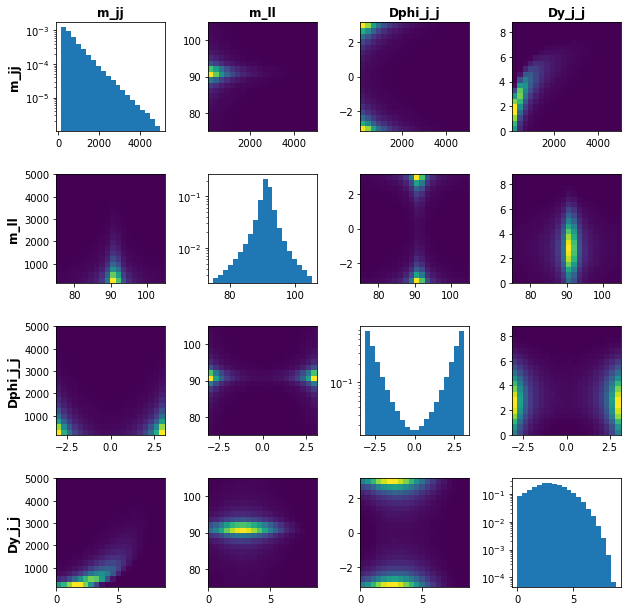

Filter efficiency is 100.000%


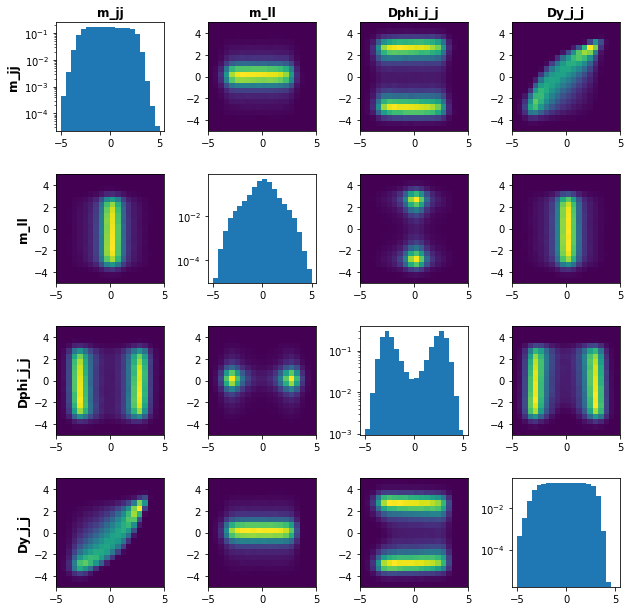

In [35]:

plot_data(observable_data  [0], weight_data   [0], keys=data.keys, bins=20, lims=True)
plot_data(white_data_to_fit[0], weights_to_fit[0], keys=data.keys, bins=20, lims=False)


In [41]:
#==================================
#===   LOAD / BUILD&FIT MODEL   ===
#==================================


#  Make sure eager execution is definitely off
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


#  Set the narrowness of the initial Gaussians (impacts postfit result)
density_model.Gauss_width_reduction_factor = 8.


#  Load model if requested, otherwise build and fit
#
if type(load_model_dir) != type(None) :
    density_model = DensityModel.from_dir(load_model_dir)
else :
    #
    #   Figure out the limits of the observables
    #
    range_limits = {}
    for idx in range(num_observables) :
        all_data   = np.concatenate([item[:,idx] for c,item in white_data_to_fit.items()])
        imin, imax = np.min(all_data), np.max(all_data)
        #imin, imax = np.min([imin, -5]), np.max([imax, 5])
        irange     = imax - imin
        #range_limits[idx] = [imin - irange/output_size_per_stage, imax + irange/output_size_per_stage] 
        range_limits[idx] = [imin, imax] 
    #
    #   Create density model  
    #
    density_model = DensityModel(name            = "EWK_density_model", 
                                 num_gaussians   = output_size_per_stage, 
                                 num_conditions  = 1, 
                                 num_observables = data.get_num_observables(), 
                                 types           = data.types,
                                 int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data.keys, data.types)) if t == int},
                                 verbose         = True,
                                 learning_rate   = learning_rate,
                                 optimiser       = optimiser,
                                 range_limits    = range_limits)
    #
    #   Fit density model
    #
    fit_times = {}
    for obs_idx in range(white_data_to_fit[0].shape[1]) :
        fit_start_time = time.time()
        num_epochs = 1
        density_model.fit(white_data_to_fit, 
                          weights_to_fit,
                          observable                = obs_idx,
                          max_epochs_per_observable = num_epochs,
                          early_stopping_patience   = early_stopping_patience,
                          early_stopping_min_delta  = early_stopping_min_delta,
                          validation_split          = validation_split,
                          batch_size_per_observable = batch_size)
        fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]


INFO       DensityModel.construct      Set model name           : EWK_density_model
INFO       DensityModel.construct      Set model num_gaussians  : 20
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 4
INFO       DensityModel.construct      Set observable types     : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.construct      Set kernel_initializer   : glorot_uniform
INFO       DensityModel.construct      Set bias_initializer     : zeros
INFO       DensityModel.build          Building model segment: EWK_density_model_observable0 for observable index 0
Creating continuous density model: EWK_density_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 20
  - range              is -6.0000 - 5.4531
  - kernel_initializer is glorot_uniform
  - bias_initializer   is zeros
Model: "EWK_density_model_observable0"
__

Model: "EWK_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_170 (Dense)               (None, 7)            14          input_39[0][0]                   
__________________________________________________________________________________________________
dense_171 (Dense)               (None, 6)            18          input_40[0][0]                   
______________________________________________________________________

INFO       DensityModel.fit            Training observable index 2
INFO       DensityModel.fit              -  Training setting: epochs = 1
INFO       DensityModel.fit              -  Training setting: batch_size = 2000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 1350626 samples, validate on 1350627 samples
1350626/1350626 [==============================] - 11s 8us/sample - loss: 1.2065e-05 - val_loss: 9.8469e-06
Fit completed in 19s
INFO       DensityModel.fit            Queued the following observable indices to train: 3
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 3
INFO       DensityModel.fit              -  Training setting: epochs = 1
INFO       DensityModel.fit           

In [42]:
#  Use this cell to add training epochs to whichever indices appear undertrained

improve_indices   = [i for i in range(num_observables)]

added_fit_times = {}
for obs_idx in improve_indices :
    fit_start_time = time.time()
    num_epochs = max_epochs + obs_idx*epoch_increase_per_level
    density_model.fit(white_data_to_fit, 
                      weights_to_fit,
                      observable                = obs_idx,
                      max_epochs_per_observable = num_epochs,
                      early_stopping_patience   = early_stopping_patience,
                      early_stopping_min_delta  = early_stopping_min_delta,
                      validation_split          = validation_split,
                      batch_size_per_observable = batch_size,
                      min_gauss_amplitude_frac  = 0.)
    added_fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]
    

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = 2000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 1350626 samples, validate on 1350627 samples
Epoch 1/1000
1350626/1350626 [==============================] - 11s 8us/sample - loss: 1.3717e-05 - val_loss: 1.0689e-05
Epoch 2/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 1.0409e-05 - val_loss: 1.0255e-05
Epoch 3/1000
1350626/1350626 [==============================] -

Train on 1350626 samples, validate on 1350627 samples
Epoch 1/1000
1350626/1350626 [==============================] - 11s 8us/sample - loss: 1.1316e-05 - val_loss: 7.8749e-06
Epoch 2/1000
1350626/1350626 [==============================] - 7s 6us/sample - loss: 7.5849e-06 - val_loss: 7.4556e-06
Epoch 3/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.3987e-06 - val_loss: 7.3641e-06
Epoch 4/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.3021e-06 - val_loss: 7.2604e-06
Epoch 5/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2243e-06 - val_loss: 7.2095e-06
Epoch 6/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.1889e-06 - val_loss: 7.1874e-06
Epoch 7/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.1614e-06 - val_loss: 7.1473e-06
Epoch 8/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.0906e-06 - val_lo

1350626/1350626 [==============================] - 8s 6us/sample - loss: 9.7094e-06 - val_loss: 9.6386e-06
Epoch 2/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 9.5903e-06 - val_loss: 9.5498e-06
Epoch 3/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 9.5223e-06 - val_loss: 9.5142e-06
Epoch 4/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 9.4964e-06 - val_loss: 9.4784e-06
Epoch 5/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 9.4589e-06 - val_loss: 9.4561e-06
Epoch 6/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 9.4494e-06 - val_loss: 9.4512e-06
Epoch 7/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 9.4386e-06 - val_loss: 9.4200e-06
Epoch 8/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 9.4023e-06 - val_loss: 9.4009e-06
Epoch 9/1000
1350626/1350626 [=======================

1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2773e-06 - val_loss: 7.2698e-06
Epoch 16/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2740e-06 - val_loss: 7.2644e-06
Epoch 17/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2707e-06 - val_loss: 7.2621e-06
Epoch 18/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2680e-06 - val_loss: 7.2600e-06
Epoch 19/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2656e-06 - val_loss: 7.2557e-06
Epoch 20/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2630e-06 - val_loss: 7.2538e-06
Epoch 21/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2613e-06 - val_loss: 7.2508e-06
Epoch 22/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2591e-06 - val_loss: 7.2513e-06
Epoch 23/1000
1350626/1350626 [===============

Epoch 83/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2274e-06 - val_loss: 7.2197e-06
Epoch 84/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2274e-06 - val_loss: 7.2233e-06
Epoch 85/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2271e-06 - val_loss: 7.2200e-06
Epoch 86/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2275e-06 - val_loss: 7.2201e-06
Epoch 87/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2274e-06 - val_loss: 7.2231e-06
Epoch 88/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2273e-06 - val_loss: 7.2195e-06
Epoch 89/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2266e-06 - val_loss: 7.2188e-06
Epoch 90/1000
1350626/1350626 [==============================] - 8s 6us/sample - loss: 7.2271e-06 - val_loss: 7.2195e-06
Epoch 91/1000
1350626/1350626 [=

In [43]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    density_model.save_to_dir(save_model_dir)

In [44]:
#  Generate a large number of datapoints
#

'''n_gen = 100000

fake_white_datapoints = {}
for cWtil in cWtil_eval_vals :
    n_gen = n_gen # len(observable_data[cWtil])
    print(f"Generating {n_gen} fake datapoints for cWtil={cWtil}")
    start = time.time()
    fake_white_datapoints[cWtil] = density_model.sample(n_gen, [cWtil])
    end = time.time()
    print(f"{n_gen} datapoints generated in {int(end-start):.0f}s")

#  Unwhiten generated data
#
print("Unwhitening the generated datapoints")
fake_datapoints = {}
for cWtil in cWtil_eval_vals :
    print(f"Unwhitening generated datapoints for cWtil={cWtil}")
    fake_datapoints [cWtil] = unwhiten_axes(fake_white_datapoints[cWtil], whitening_funcs)'''


'n_gen = 100000\n\nfake_white_datapoints = {}\nfor cWtil in cWtil_eval_vals :\n    n_gen = n_gen # len(observable_data[cWtil])\n    print(f"Generating {n_gen} fake datapoints for cWtil={cWtil}")\n    start = time.time()\n    fake_white_datapoints[cWtil] = density_model.sample(n_gen, [cWtil])\n    end = time.time()\n    print(f"{n_gen} datapoints generated in {int(end-start):.0f}s")\n\n#  Unwhiten generated data\n#\nprint("Unwhitening the generated datapoints")\nfake_datapoints = {}\nfor cWtil in cWtil_eval_vals :\n    print(f"Unwhitening generated datapoints for cWtil={cWtil}")\n    fake_datapoints [cWtil] = unwhiten_axes(fake_white_datapoints[cWtil], whitening_funcs)'

In [45]:
#  Generate a large number of datapoints at 0.
#

n_gen = 5000

print(f"Generating {n_gen} fake datapoints for cWtil=[0]")
start = time.time()

fake_white_datapoints_SM = density_model.sample(n_gen, [0])
end = time.time()
print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")

#  Unwhiten generated data
#

print("Unwhitening fake datapoints for cWtil=0")
start = time.time()
fake_datapoints_SM = unwhiten_axes(fake_white_datapoints_SM, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened at cWtil=0 in {int(end-start):.0f}s")


n_gen = 500000

print(f"Generating {n_gen} fake datapoints for cWtil=[0]")
start = time.time()

fake_white_datapoints_SM_big = density_model.sample(n_gen, [0])
end = time.time()
print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")

#  Unwhiten generated data
#

print("Unwhitening fake datapoints for cWtil=0")
start = time.time()
fake_datapoints_SM_big = unwhiten_axes(fake_white_datapoints_SM_big, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened at cWtil=0 in {int(end-start):.0f}s")


Generating 5000 fake datapoints for cWtil=[0]
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 3
5000 datapoints generated at cWtil=0 in 16s
Unwhitening fake datapoints for cWtil=0
5000 datapoints unwhitened at cWtil=0 in 0s
Generating 500000 fake datapoints for cWtil=[0]
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 315s
Unwhitening fake datapoints

In [46]:
#  Get datapoint likelihoods at 0 hypothesis
#

fake_datapoint_SM_likelihood = density_model.evaluate(0, fake_white_datapoints_SM)

fake_datapoint_weights = {}
for cWtil in cWtil_eval_vals :
    start = time.time()
    fake_datapoint_weights [cWtil] = density_model.evaluate(cWtil, fake_white_datapoints_SM) / fake_datapoint_SM_likelihood
    end = time.time()
    print(f"{len(fake_white_datapoints_SM)} datapoints evaluated at cWtil = {cWtil} in {(end-start):.2f}s")
    start = time.time()
    dataset_NLL = density_model.get_NLL(cWtil, fake_white_datapoints_SM)
    end = time.time()
    print(f"-- NLL = {dataset_NLL}, eval time is {(end-start):.2f}s")


5000 datapoints evaluated at cWtil = 0 in 4.48s
-- NLL = 8.172767113542557, eval time is 16.53s
5000 datapoints evaluated at cWtil = -0.4 in 4.98s
-- NLL = 8.161352725839615, eval time is 0.94s
5000 datapoints evaluated at cWtil = -0.3 in 4.98s
-- NLL = 8.168004632925987, eval time is 0.90s
5000 datapoints evaluated at cWtil = -0.2 in 4.99s
-- NLL = 8.170055732536316, eval time is 0.85s
5000 datapoints evaluated at cWtil = -0.1 in 4.77s
-- NLL = 8.170749340343475, eval time is 0.85s
5000 datapoints evaluated at cWtil = 0.1 in 4.72s
-- NLL = 8.175462544131278, eval time is 0.86s
5000 datapoints evaluated at cWtil = 0.2 in 4.63s
-- NLL = 8.179086504292489, eval time is 0.91s
5000 datapoints evaluated at cWtil = 0.3 in 4.79s
-- NLL = 8.183582297730446, eval time is 0.98s
5000 datapoints evaluated at cWtil = 0.4 in 4.75s
-- NLL = 8.186170860004426, eval time is 0.84s


Filter efficiency is 100.000%


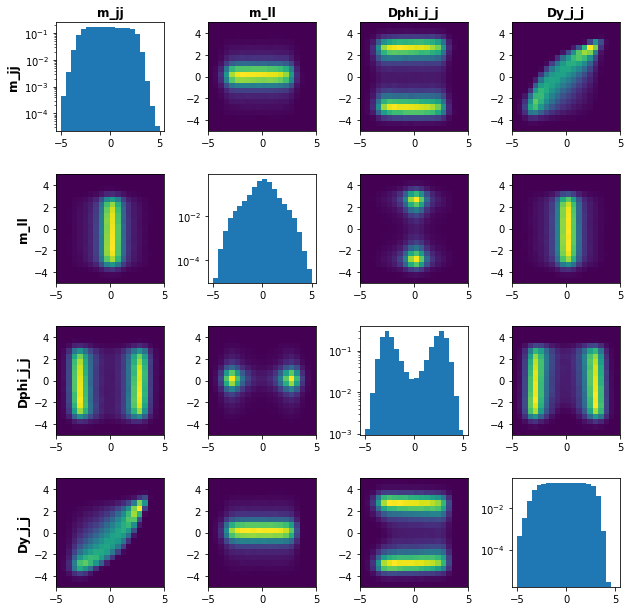

Filter efficiency is 100.000%


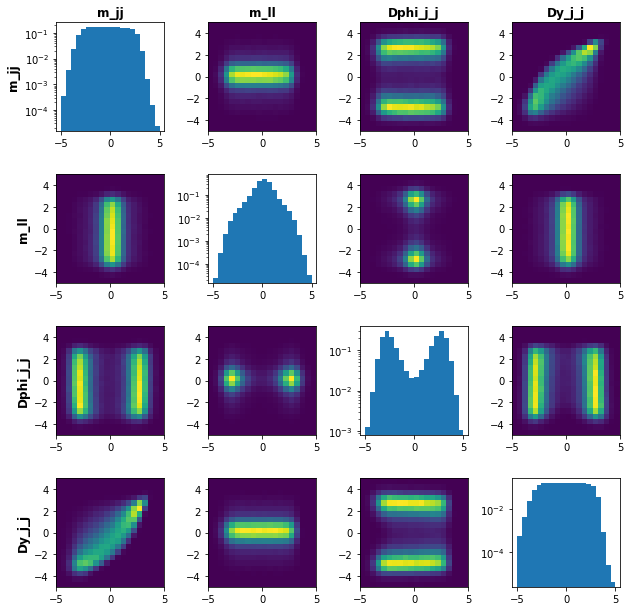

In [47]:
#  Plot original and generate data (total phase space)

plot_data(white_data_to_fit[0]        , weights_to_fit[0], keys=data.keys, bins=20, lims=False)
plot_data(fake_white_datapoints_SM_big, None             , keys=data.keys, bins=20, lims=False)


Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value enco

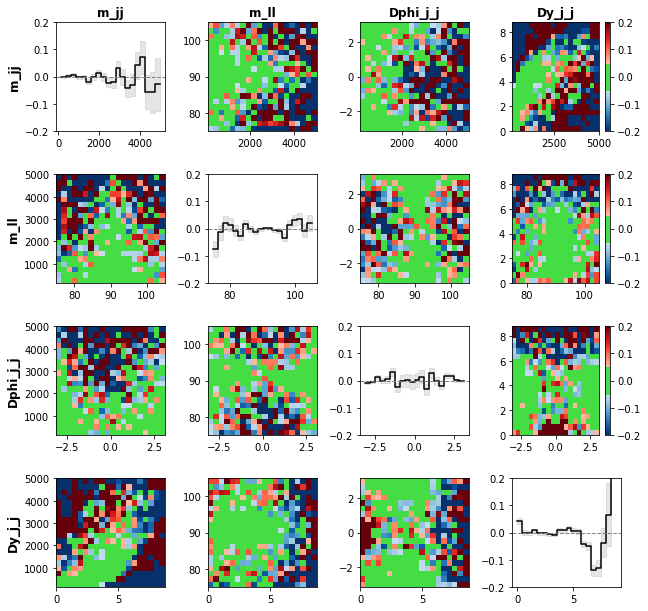

In [48]:
#  Plot ratio and pull between original and generated data (total phase space)

plot_ratio(observable_data[0]  , fake_datapoints_SM_big, weights_to_fit[0], None, keys=data.keys, bins=20)


In [49]:

#  Remove events for which key lies outside the interval [minimum, maximum]
#
def filter_data (events, weights, keys, key, minimum, maximum) :
    col_idx = keys.index(key)
    new_events, new_weights = [], []
    for row, weight in zip(events, weights) :
        val = row[col_idx]
        if val < minimum : continue
        if val > maximum : continue
        new_events.append(row)
        new_weights.append(weight)
    return np.array(new_events), np.array(new_weights)


#  Plot the datapoints provided
#
def plot_observable (observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    print(f"Numerator filter efficiency is {100.*np.sum(filtered_weights_num)/np.sum(weights_num):.3f}%")
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    print(f"Denominator filter efficiency is {100.*np.sum(filtered_weights_den)/np.sum(weights_den):.3f}%")
    
    obs_idx = keys.index(observable)
    
    if lims : 
        obs_lims = observable_limits[observable]
    else :
        obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(observable, weight="bold", fontsize=12)
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k", label=label)
    
    #ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.2, color="grey")
    
    ax.axhline(0 , linestyle="-", c="grey", linewidth=2)
    ax.axhline(0.1 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.2 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.3 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.4 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.1 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.2 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.3 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.4 , linestyle="--", c="grey", linewidth=0.5)
    ax.set_ylim([-0.9, 0.9])
    
    if type(label) != type(None) :
        ax.legend(loc="upper right", frameon=False, fontsize=16)
    
    plt.show()

In [50]:
#  Plot the datapoints provided
#
def get_eff (data, weights=None, keys=[], cuts=[]) :
    if type(weights) == type(None) :
        weights = np.ones(shape=(data.shape[0],))
    filtered_data, filtered_weights = data, weights
    for cut in cuts :
        filtered_data, filtered_weights = filter_data (filtered_data, filtered_weights, keys, cut[0], cut[1], cut[2])
    return 100.*np.sum(filtered_weights)/np.sum(weights), 100.*np.sqrt(np.sum(filtered_weights*filtered_weights))/np.sum(weights)


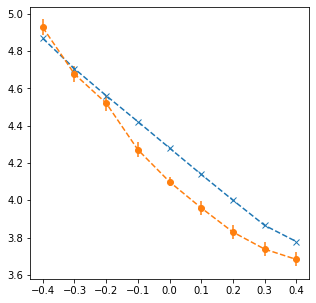

In [51]:
#  Plot data (VBF fiducial)

cuts = []
cuts.append(["m_jj"    , 1000, 5000])
cuts.append(["Dy_j_j"  , 2   , 8.8 ])

x1, x2, y1, y2, ey2 = [], [], [], [], []

for cWtil in sorted(cWtil_eval_vals) :
    e1 = get_eff(fake_datapoints_SM, weights=fake_datapoint_weights[cWtil], keys=data.keys, cuts=[["Dphi_j_j", -1.5, 0]])
    x1.append(cWtil)
    y1.append(e1[0])
    
for cWtil in sorted(cWtil_vals) :
    e2 = get_eff(observable_data[cWtil], weights_to_fit[cWtil], keys=data.keys, cuts=[["Dphi_j_j", -1.5, 0]])
    x2.append(cWtil)
    y2.append(e2[0])
    ey2.append(e2[1])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x1, y1, "x--")
ax.errorbar(x2, y2, yerr=ey2, fmt="o--")
plt.show()

In [52]:
#  Get a plot label for each observable
#

obs_labels = {}
obs_labels ["m_jj"    ] = r"$m_{jj}$  [TeV]"
obs_labels ["m_ll"    ] = r"$m_{ll}$  [GeV]"
obs_labels ["Dphi_j_j"] = r"$\Delta\phi\left(j,j\right)$"
obs_labels ["Dy_j_j"  ] = r"$\Delta y\left(j,j\right)$"

def get_obs_label (obs) :
    if obs in obs_labels :
        return obs_labels[obs]
    return obs


#  Plot the datapoints provided
#
def plot_observable_on_axis (ax, observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None, normed=True, ebar=False) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True, normed=normed)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k", label=label)
    if ebar :ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.3, color="grey")
    ax.set_xlim([bins[0], bins[-1]])
    
    ax.axhline(0    , linestyle="-" , c="grey", linewidth=2  )
    for h in [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4] :
        ax.axhline(h, linestyle="--", c="grey", linewidth=0.5)


#  Plot the datapoints provided
#
def plot_observable_on_axis2 (ax, observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None, linecolor="k", fillcolor="grey", normed=True, ebar=False) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True, normed=normed)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color=linecolor, label=label, linewidth=2)
    if ebar : ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.4, color=fillcolor)
        
    return data_x, data_z, data_ez
        

In [53]:
#  For making GIFs

'''
for fig_idx, cWtil in enumerate(sorted(cWtil_eval_vals)) :
    fig = plt.figure(figsize=(2*num_observables, 7))
    for idx, obs in enumerate(observables_order) :
        ax1 = fig.add_subplot(2, num_observables, 1+idx)
        data = data_tables [cWtil]
        observables, weights = data.get_observables_and_weights()
        plot_observable_on_axis (ax1, obs, observables, observable_data[0], weights, weights_to_fit[0], keys=data.keys, bins=20, normed=True, ebar=True)
        ax1.get_xaxis().set_ticklabels([])
        ax2 = fig.add_subplot(2, num_observables, num_observables+1+idx)
        plot_observable_on_axis (ax2, obs, fake_datapoints_SM, fake_datapoints_SM, fake_datapoint_weights[cWtil], fake_datapoint_weights[0], keys=data.keys, bins=20, normed=True)
        ax2.set_xlabel(get_obs_label(obs), fontsize=19, labelpad=20)
        if idx == 0 :
            ax1.set_ylabel("MG5 events"   , fontsize=19, labelpad=20, weight="bold")
            ax2.set_ylabel("Density model", fontsize=19, labelpad=20, weight="bold")
        else :
            ax1.get_yaxis().set_ticklabels([])
            ax2.get_yaxis().set_ticklabels([])
        if idx == num_observables-1 :
            ax1.text(0.86, 0.92, r"$\frac{\sigma({\tilde c}_W="+f"{cWtil:.1f})~~[N={observables.shape[0]}]"+r"}{\sigma_{SM}"+f"~~~~~~~~~~~~~~~~[N={observable_data[0].shape[0]}]"+"}$"       , fontsize=19, transform=ax1.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='grey', pad=4.0))
            ax2.text(0.86, 0.92, r"$\frac{\sigma({\tilde c}_W="+f"{cWtil:.1f})~~[N={fake_datapoints_SM.shape[0]}]"+r"}{\sigma_{SM}"+f"~~~~~~~~~~~~~~~~[N={fake_datapoints_SM.shape[0]}]"+"}$", fontsize=19, transform=ax2.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='grey', pad=4.0))
        ax1.set_ylim([-0.69, 0.99])
        ax2.set_ylim([-0.69, 0.99])
        ax1.tick_params(which="both", right=True, top=True, labelsize=12)
        ax2.tick_params(which="both", right=True, top=True, labelsize=12)
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig(f"figures/EWK_cWtil_dependence_{fig_idx}.png", bbox_inches="tight")
    plt.show()
'''

'\nfor fig_idx, cWtil in enumerate(sorted(cWtil_eval_vals)) :\n    fig = plt.figure(figsize=(2*num_observables, 7))\n    for idx, obs in enumerate(observables_order) :\n        ax1 = fig.add_subplot(2, num_observables, 1+idx)\n        data = data_tables [cWtil]\n        observables, weights = data.get_observables_and_weights()\n        plot_observable_on_axis (ax1, obs, observables, observable_data[0], weights, weights_to_fit[0], keys=data.keys, bins=20, normed=True, ebar=True)\n        ax1.get_xaxis().set_ticklabels([])\n        ax2 = fig.add_subplot(2, num_observables, num_observables+1+idx)\n        plot_observable_on_axis (ax2, obs, fake_datapoints_SM, fake_datapoints_SM, fake_datapoint_weights[cWtil], fake_datapoint_weights[0], keys=data.keys, bins=20, normed=True)\n        ax2.set_xlabel(get_obs_label(obs), fontsize=19, labelpad=20)\n        if idx == 0 :\n            ax1.set_ylabel("MG5 events"   , fontsize=19, labelpad=20, weight="bold")\n            ax2.set_ylabel("Density mod

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value e

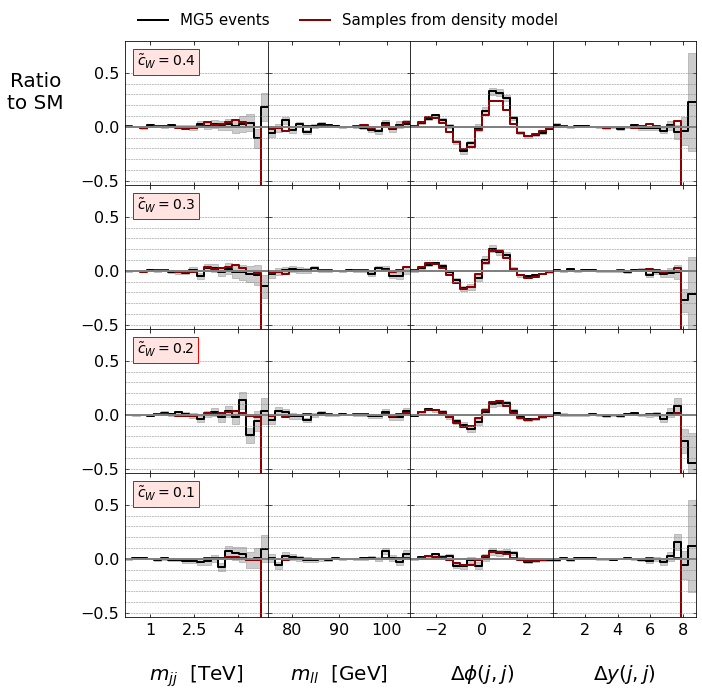

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value e

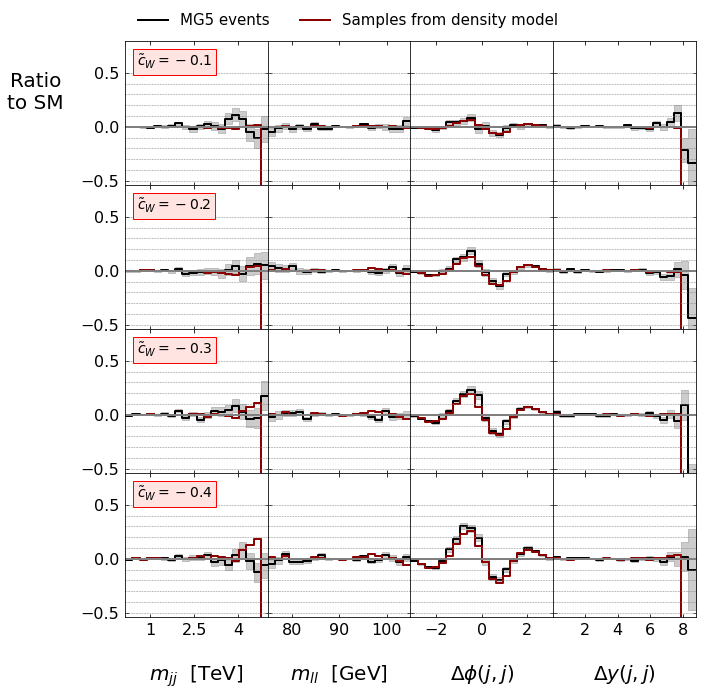

In [54]:
columns = [[0.4, 0.3, 0.2, 0.1], [-0.1, -0.2, -0.3, -0.4]]

for col_idx, column in enumerate(columns) :
    num_c_in_col  = len(column)
    height, width = 2+2*num_c_in_col, 2*num_observables
    fig           = plt.figure(figsize=(width, height))
    first_axis    = None
    for c_idx, cWtil in enumerate(column) :
        pad_xlo, pad_xwidth = 0.01, 0.99
        pad_ylo, pad_yheight = 1.-(1+c_idx)*2./height, 2./height
        for obs_idx, obs in enumerate(observables_order) :
            ax   = fig.add_axes([pad_xlo+obs_idx*pad_xwidth/num_observables, pad_ylo, pad_xwidth/num_observables, pad_yheight])
            data = data_tables [cWtil]
            observables, weights = data.get_observables_and_weights()
            data_x, _, _ = plot_observable_on_axis2 (ax, obs, observables, observable_data[0], weights, weights_to_fit[0], keys=data.keys, bins=20, normed=True, ebar=True, label="MG5 events")
            data_x, _, _ = plot_observable_on_axis2 (ax, obs, fake_datapoints_SM, fake_datapoints_SM, fake_datapoint_weights[cWtil], fake_datapoint_weights[0], keys=data.keys, bins=20, normed=True, label="Samples from density model", linecolor="darkred", fillcolor="red")
            ax.set_xlim([data_x[0], data_x[-1]])
            ax.axhline(0, linestyle="-" , c="grey", linewidth=2  )
            for h in [-0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5] :
                ax.axhline(h, linestyle="--", c="grey", linewidth=0.5)
            if obs_idx == 0 :
                ax.text(0.08, 0.92, r"${\tilde c}_W="+f"{cWtil:.1f}$", fontsize=14, transform=ax.transAxes, ha="left", va="top", bbox=dict(facecolor='mistyrose', edgecolor='red', pad=4.0))
                if c_idx == 0 :
                    ax.set_ylabel("Ratio\nto SM", fontsize=20, labelpad=45, rotation=0)
            else :
                ax.get_yaxis().set_ticklabels([])
            ax.set_ylim([-0.54, 0.79])
            ax.tick_params(which="both", right=True, top=True, labelsize=16, pad=6, direction="in")
            if type(first_axis) == type(None) : first_axis = ax
            if obs_idx == 0 : 
                ax.set_xticks([1000, 2500, 4000])
                ax.get_xaxis().set_ticklabels(["1" , "2.5", "4" ])
            if obs_idx == 1 : ax.set_xticks([80, 90, 100])
            if obs_idx == 2 : ax.set_xticks([-2, 0, 2])
            if obs_idx == 3 : ax.set_xticks([2, 4, 6, 8])
            if c_idx == num_c_in_col-1 :
                ax.set_xlabel(get_obs_label(obs), fontsize=20, labelpad=25)
            else :
                ax.get_xaxis().set_ticklabels([])
    first_axis.legend(loc=(0.05, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=15)
    plt.savefig(f"figures/whitening_method/EWK_events_cWtil_col{col_idx}.pdf", bbox_inches="tight")
    plt.show()


In [55]:
'''columns = [[0.4, 0.3, 0.2, 0.1],-0.1, -0.2, -0.3, -0.4]]

for column in columns :
    num_c_in_col  = len(column)
    height, width = 2+2*num_c_in_col, 2*num_observables
    fig           = plt.figure(figsize=(width, height))
    first_axis    = None
    for c_idx, cWtil in enumerate(column) :
        pad_xlo, pad_xwidth = 0.01, 0.99
        pad_ylo, pad_yheight = 1.-(1+c_idx)*2./height, 2./height
        for obs_idx, obs in enumerate(observables_order) :
            ax   = fig.add_axes([pad_xlo+obs_idx*pad_xwidth/num_observables, pad_ylo, pad_xwidth/num_observables, pad_yheight])
            data = data_tables [cWtil]
            observables, weights = data.get_observables_and_weights()
            data_x, _, _ = plot_observable_on_axis2 (ax, obs, observables, observable_data[0], weights, weights_to_fit[0], keys=data.keys, bins=20, normed=True, ebar=True, label="MG5 events", cuts=cuts)
            data_x, _, _ = plot_observable_on_axis2 (ax, obs, fake_datapoints_SM, fake_datapoints_SM, fake_datapoint_weights[cWtil], fake_datapoint_weights[0], keys=data.keys, bins=20, normed=True, label="Samples from density model", linecolor="darkred", fillcolor="red", cuts=cuts)
            ax.set_xlim([data_x[0], data_x[-1]])
            ax.axhline(0, linestyle="-" , c="grey", linewidth=2  )
            for h in [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4] :
                ax.axhline(h, linestyle="--", c="grey", linewidth=0.5)
            if c_idx == num_c_in_col-1 :
                ax.set_xlabel(get_obs_label(obs), fontsize=19, labelpad=20)
            else :
                ax.get_xaxis().set_ticklabels([])
            if obs_idx == 0 :
                ax.text(0.08, 0.92, r"${\tilde c}_W="+f"{cWtil:.1f}$", fontsize=14, transform=ax.transAxes, ha="left", va="top", bbox=dict(facecolor='red', alpha=0.2, edgecolor='red', pad=4.0))
                if c_idx == 0 :
                    ax.set_ylabel("Ratio\nto SM", fontsize=19, labelpad=40, rotation=0, weight="bold")
            else :
                ax.get_yaxis().set_ticklabels([])
            ax.set_ylim([-0.54, 0.79])
            ax.tick_params(which="both", right=True, top=True, labelsize=13, pad=5, direction="in")
            if type(first_axis) == type(None) : first_axis = ax
    first_axis.legend(loc=(0.05, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=15)
    plt.savefig(f"figures/whitening_method/EWK_events_cWtil_fid.pdf", bbox_inches="tight")
    plt.show()
'''

'columns = [[0.4, 0.3, 0.2, 0.1],-0.1, -0.2, -0.3, -0.4]]\n\nfor column in columns :\n    num_c_in_col  = len(column)\n    height, width = 2+2*num_c_in_col, 2*num_observables\n    fig           = plt.figure(figsize=(width, height))\n    first_axis    = None\n    for c_idx, cWtil in enumerate(column) :\n        pad_xlo, pad_xwidth = 0.01, 0.99\n        pad_ylo, pad_yheight = 1.-(1+c_idx)*2./height, 2./height\n        for obs_idx, obs in enumerate(observables_order) :\n            ax   = fig.add_axes([pad_xlo+obs_idx*pad_xwidth/num_observables, pad_ylo, pad_xwidth/num_observables, pad_yheight])\n            data = data_tables [cWtil]\n            observables, weights = data.get_observables_and_weights()\n            data_x, _, _ = plot_observable_on_axis2 (ax, obs, observables, observable_data[0], weights, weights_to_fit[0], keys=data.keys, bins=20, normed=True, ebar=True, label="MG5 events", cuts=cuts)\n            data_x, _, _ = plot_observable_on_axis2 (ax, obs, fake_datapoints_SM, fa

In [56]:
'''
fig = plt.figure(figsize=(2*num_observables, 5))
for idx, obs in enumerate(observables_order) :
    ax = fig.add_subplot(1, num_observables, 1+idx)
    datapoints_true, weights_true = data_tables [0].get_observables_and_weights()
    plot_observable_on_axis (ax, obs, fake_datapoints_SM_big, datapoints_true, None, weights_true, keys=data.keys, bins=20, normed=True, ebar=True)
    ax.set_xlabel(obs, weight="bold", fontsize=19, labelpad=20)
    if idx == 0 :
        ax.set_ylabel(f"Ratio to MG5 [N={datapoints_true.shape[0]}]", fontsize=19, labelpad=20, weight="bold")
    else :
        ax.set_yticks([])
    if idx == num_observables-1 :
        ax.text(0.5, 0.92, r"${\rm Density~model}~({\tilde c}_{\rm W}="+f"0)$ [N={fake_datapoints_SM_big.shape[0]}]", fontsize=16, transform=ax.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='grey', pad=10.0))
    ax.set_ylim([-0.7, 1.])
plt.subplots_adjust(wspace=0)
plt.savefig(f"figures/EWK_ratio_at_SM.pdf", bbox_inches="tight")
plt.show()
'''

'\nfig = plt.figure(figsize=(2*num_observables, 5))\nfor idx, obs in enumerate(observables_order) :\n    ax = fig.add_subplot(1, num_observables, 1+idx)\n    datapoints_true, weights_true = data_tables [0].get_observables_and_weights()\n    plot_observable_on_axis (ax, obs, fake_datapoints_SM_big, datapoints_true, None, weights_true, keys=data.keys, bins=20, normed=True, ebar=True)\n    ax.set_xlabel(obs, weight="bold", fontsize=19, labelpad=20)\n    if idx == 0 :\n        ax.set_ylabel(f"Ratio to MG5 [N={datapoints_true.shape[0]}]", fontsize=19, labelpad=20, weight="bold")\n    else :\n        ax.set_yticks([])\n    if idx == num_observables-1 :\n        ax.text(0.5, 0.92, r"${\rm Density~model}~({\tilde c}_{\rm W}="+f"0)$ [N={fake_datapoints_SM_big.shape[0]}]", fontsize=16, transform=ax.transAxes, ha="right", va="top", bbox=dict(facecolor=\'white\', edgecolor=\'grey\', pad=10.0))\n    ax.set_ylim([-0.7, 1.])\nplt.subplots_adjust(wspace=0)\nplt.savefig(f"figures/EWK_ratio_at_SM.pdf", 

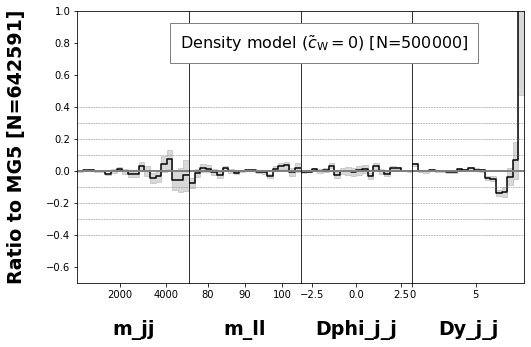

In [57]:

fig = plt.figure(figsize=(2*num_observables, 5))
for idx, obs in enumerate(observables_order) :
    ax = fig.add_subplot(1, num_observables, 1+idx)
    datapoints_true, weights_true = data_tables [0].get_observables_and_weights()
    plot_observable_on_axis (ax, obs, fake_datapoints_SM_big, datapoints_true, None, weights_true, keys=data.keys, bins=20, normed=True, ebar=True)
    ax.set_xlabel(obs, weight="bold", fontsize=19, labelpad=20)
    if idx == 0 :
        ax.set_ylabel(f"Ratio to MG5 [N={datapoints_true.shape[0]}]", fontsize=19, labelpad=20, weight="bold")
    else :
        ax.set_yticks([])
    if idx == num_observables-1 :
        ax.text(0.5, 0.92, r"${\rm Density~model}~({\tilde c}_{\rm W}="+f"0)$ [N={fake_datapoints_SM_big.shape[0]}]", fontsize=16, transform=ax.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='grey', pad=10.0))
    ax.set_ylim([-0.7, 1.])
plt.subplots_adjust(wspace=0)
plt.savefig(f"figures/EWK_ratio_at_SM.pdf", bbox_inches="tight")
plt.show()


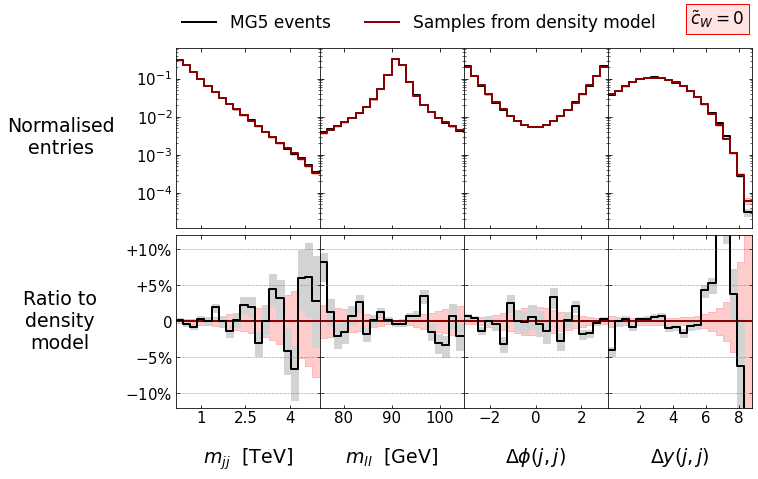

In [58]:

#  Data space distribution & ratio (c=0)
def histo_to_line (bins, values, errors) :
    X, Z, EZ = [], [], []
    for zp in values :
        Z .append(zp)
        Z .append(zp)
    for ezp in errors :
        EZ.append(ezp)
        EZ.append(ezp)
    for i in range(len(bins)-1) :
        X .append(bins[i])
        X .append(bins[i+1])
    return np.array(X), np.array(Z), np.array(EZ)


fig = plt.figure(figsize=(8, 5))

axes1, axes2 = [], []
ylos , yhis  = [], []

for obs_idx, observable in enumerate(observables_order) :
    
    #  Get axis x coordinates
    xlo    = obs_idx / num_observables
    xwidth = 1.      / num_observables
    
    #  ============
    #     AXIS 1
    #  ============

    ax1 = fig.add_axes([xlo, 0.50, xwidth, 0.5])
    
    datapoints_true, weights_true = data_tables [0].get_observables_and_weights()
    
    obs_lims   = observable_limits[observable]
    num_bins   = 20
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], num_bins+1)
        
    hvals1, _ = np.histogram(datapoints_true       [:,obs_idx], bins=bins, weights=weights_true             )
    herrs1, _ = np.histogram(datapoints_true       [:,obs_idx], bins=bins, weights=weights_true*weights_true)
    herrs1    = np.sqrt(herrs1)
    hvals1, herrs1 = hvals1/np.sum(weights_true), herrs1/np.sum(weights_true)
    #hvals1, herrs1 = hvals1/np.max(hvals1), herrs1/np.max(hvals1)
    hvals2, _ = np.histogram(fake_datapoints_SM_big[:,obs_idx], bins=bins)
    herrs2    = np.sqrt(hvals2)
    hvals2, herrs2 = hvals2/len(fake_datapoints_SM_big), herrs2/len(fake_datapoints_SM_big)
    #hvals2, herrs2 = hvals2/np.max(hvals2), herrs2/np.max(hvals2)
    
    plot_x, plot_y1, plot_ey1 = histo_to_line(bins, hvals1, herrs1)
    _     , plot_y2, plot_ey2 = histo_to_line(bins, hvals2, herrs2)
    
    ax1.plot(plot_x, plot_y1, "-", color="k"      , linewidth=2, label="MG5 events")
    ax1.fill_between(plot_x, plot_y1-plot_ey1, plot_y1+plot_ey1, color="lightgrey", alpha=1)
    ax1.plot(plot_x, plot_y2, "-", color="darkred", linewidth=2, label="Samples from density model")
    ax1.fill_between(plot_x, plot_y2-plot_ey2, plot_y2+plot_ey2, color="red", alpha=0.2)
    ax1.set_yscale("log")
    
    # Save y values range
    ylo, yhi = np.min([plot_y1-plot_ey1, plot_y2-plot_ey2]), np.max([plot_y1+plot_ey1, plot_y2+plot_ey2])
    ylos.append(ylo)
    yhis.append(yhi)
        
    
    #  ============
    #     AXIS 2
    #  ============

    ax2 = fig.add_axes([xlo, 0, xwidth, 0.48])
    
    ax2.axhline(0, c="darkred", linewidth=2)
    ax2.fill_between(plot_x, -plot_ey2/plot_y2, plot_ey2/plot_y2, color="red", alpha=0.2)
    ax2.plot(plot_x, (plot_y1-plot_y2)/plot_y2, c="k", linewidth=2)
    ax2.fill_between(plot_x, (plot_y1-plot_ey1-plot_y2)/plot_y1, (plot_y1+plot_ey1-plot_y2)/plot_y1, color="lightgrey", alpha=1)
    ax2.set_ylim([-0.12, 0.12])
    
    for h in [-0.1, -0.05, 0.05, 0.1] :
        ax2.axhline(h, linestyle="--", c="grey", linewidth=0.5)
    
    #  Set y axis tick labels    
    if obs_idx > 0 :
        ax1.get_yaxis().set_ticklabels([])
        ax2.get_yaxis().set_ticklabels([])
        
    #  Set x axis tick labels
    ax1.get_xaxis().set_ticklabels([])
    if obs_idx == 0 : 
        ax1.set_xticks([1000, 2500, 4000])
        ax2.set_xticks([1000, 2500, 4000])
        ax2.get_xaxis().set_ticklabels(["1" , "2.5", "4" ])
    if obs_idx == 1 : 
        ax1.set_xticks([80, 90, 100])
        ax2.set_xticks([80, 90, 100])
    if obs_idx == 2 : 
        ax1.set_xticks([-2, 0, 2])
        ax2.set_xticks([-2, 0, 2])
    if obs_idx == 3 : 
        ax1.set_xticks([2, 4, 6, 8])
        ax2.set_xticks([2, 4, 6, 8])
        
    #  Set x axis labels
    ax2.set_xlabel(get_obs_label(observable), fontsize=19, labelpad=20)
        
    #  Set y axis labels
    if obs_idx == 0 : 
        ax1.set_ylabel("Normalised\nentries", fontsize=19, labelpad=75, rotation=0, va="center")
        ax2.set_ylabel("Ratio to\ndensity\nmodel", fontsize=19, labelpad=65, rotation=0, va="center")
        ax1.legend(loc=(0, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=17)
      
    #  Draw cWtil label
    if obs_idx == (num_observables-1) : 
        ax1.text(0.95, 1.1, r"${\tilde c}_W=0$", fontsize=17, transform=ax1.transAxes, ha="right", va="bottom", bbox=dict(facecolor='mistyrose', edgecolor='red', pad=4.0))
    
    #  Set x limits
    ax1.set_xlim([bins[0], bins[-1]])
    ax2.set_xlim([bins[0], bins[-1]])
    
    #  Set tick params
    ax1.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
    ax2.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
    
    #  Save axes
    axes1.append(ax1)
    axes2.append(ax2)

        
#  Set consistent axis y lims
for ax in axes1 :
    ax.set_ylim([np.min(ylos)/2., 2.*np.max(yhis)])

'''axes1[0].set_yticks     ([1, 0.1, 0.01, 0.001])
axes1[0].set_yticklabels([r"$100\%$", r"$10\%$", r"$1\%$", r"$0.1\%$"])'''

axes2[0].set_yticks     ([-0.1, -0.05, 0, 0.05, 0.1])
axes2[0].set_yticklabels([r"$-10\%$", r"$-5\%$", r"$0$", r"$+5\%$", r"$+10\%$"])
 
plt.savefig(f"figures/whitening_method/1D_distributions_density_model.pdf", bbox_inches="tight")
plt.show()


In [59]:
def plot_data_adv (datapoints, weights=None, label="", savefig="") :
    
    #  If no weights provided then assume uniform
    if type(weights) == type(None) :
        weights = np.ones(shape=(datapoints.shape[0],))
    
    #  Get histo bins
    get_bins = {}
    for obs_idx_x, obs_x in enumerate(observables_order) :
        obs_lims_x = observable_limits[obs_x]
        num_bins_x = 20
        if obs_x in int_observables : get_bins[obs_idx_x] = np.linspace(obs_lims_x[0]-0.5, obs_lims_x[1]+0.5, 1+(obs_lims_x[1]-obs_lims_x[0]))
        else                        : get_bins[obs_idx_x] = np.linspace(obs_lims_x[0], obs_lims_x[1], num_bins_x+1)

    #  First figure out our colour axis limits
    #     whilst we're at it, save the list of indices to plot (to make sure all loops are over consistent sets)
    vmin = 1e30
    observables_for_x, observables_for_y = [], []
    for obs_idx_x, obs_x in enumerate(observables_order) :
        #  Don't plot observable -1 on x axis
        if obs_idx_x == num_observables-1 : continue
        observables_for_x.append(obs_idx_x)
        for obs_idx_y, obs_y in enumerate(observables_order) :
            #  Don't plot observable 0 or above diagonal on y axis
            if obs_idx_y == 0         : continue
            if obs_idx_y <= obs_idx_x : continue
            observables_for_y.append(obs_idx_y)
            #  Get histo limits
            bins_x, bins_y = get_bins[obs_idx_x], get_bins[obs_idx_y]
            vals, _, _ = np.histogram2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights, bins=(bins_x, bins_y))
            vals = vals.flatten()
            vals_min, vals_max = np.nanmin([v for v in vals if v > 0]), np.nanmax([v for v in vals if v > 0])
            vmin = np.nanmin([vmin, vals_min/vals_max])

    #  Make plot
    fig = plt.figure(figsize=(8, 5))
    vmin = 1e-5

    for obs_idx_x, obs_x in enumerate(observables_order) :

        #  Check whether we want to plot observable x
        if obs_idx_x not in observables_for_x : continue

        #  Get axis x coordinates
        xlo    = obs_idx_x / (num_observables-1)
        xwidth = 1.        / (num_observables-1)

        for obs_idx_y, obs_y in enumerate(observables_order) :

            #  Check whether we want to plot observable y
            if obs_idx_y not in observables_for_y : continue
            if obs_idx_y <= obs_idx_x : continue

            #  Get axis y coordinates
            ylo     = (num_observables-obs_idx_y-1) / (num_observables-1)
            yheight = 1.                            / (num_observables-1)

            #  Create axis
            ax = fig.add_axes([xlo, ylo, 0.95*xwidth, 0.95*yheight])

            #  Decide whether to draw axis labels
            if obs_idx_x != 0 : ax.get_yaxis().set_ticklabels([])
            else : 
                ax.set_ylabel(get_obs_label(obs_y), fontsize=19, labelpad=20)
            if obs_idx_y != num_observables-1 : ax.get_xaxis().set_ticklabels([])
            else : 
                ax.set_xlabel(get_obs_label(obs_x), fontsize=19, labelpad=20)
            
            if (obs_idx_x == 0) and (obs_idx_y == num_observables-1) : ax.get_xaxis().set_ticklabels(["1" , "2.5", "4" ])
            if (obs_idx_x == 0) and (obs_idx_y == 0) : ax.get_yaxis().set_ticklabels(["1" , "2.5", "4" ])
            if obs_idx_x == 0 : ax.set_xticks([1000, 2500, 4000])
            if obs_idx_x == 1 : ax.set_xticks([80, 90, 100])
            if obs_idx_x == 2 : ax.set_xticks([-2, 0, 2])
            if obs_idx_x == 3 : ax.set_xticks([2, 4, 6, 8])
        
            #  Format tick params
            ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)

            #  Draw histogram
            bins_x, bins_y = get_bins[obs_idx_x], get_bins[obs_idx_y]
            _, _, _, patches = ax.hist2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights/vals_max, bins=(bins_x, bins_y),
                                      vmin=vmin, vmax=1, norm=colors.LogNorm())
            
            if (obs_idx_x==0) and (obs_idx_y==1) and len(label) > 0 :
                ax.text(0, 1.2, r"${\tilde c}_W=0$", fontsize=21, transform=ax.transAxes, ha="left", va="bottom", bbox=dict(facecolor='mistyrose', edgecolor='red', pad=4.0))
                ax.text(0.5, 1.2, label, weight="bold", ha="left", va="bottom", transform=ax.transAxes, fontsize=21)
                

    cbar_ax = fig.add_axes([0.76, 0.5, 0.03, 0.45])
    cbar    = fig.colorbar(patches, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=14)
    cbar   .set_ticks([1, 0.1, 0.01, 0.001, 0.0001, 1e-5])
    cbar   .set_label(r"$\frac{p(x)}{{\rm max}~p(x)}$", fontsize=25, labelpad=50, rotation=0, va="center")

    if len(savefig) > 0 :
        plt.savefig(savefig, bbox_inches="tight")
    plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


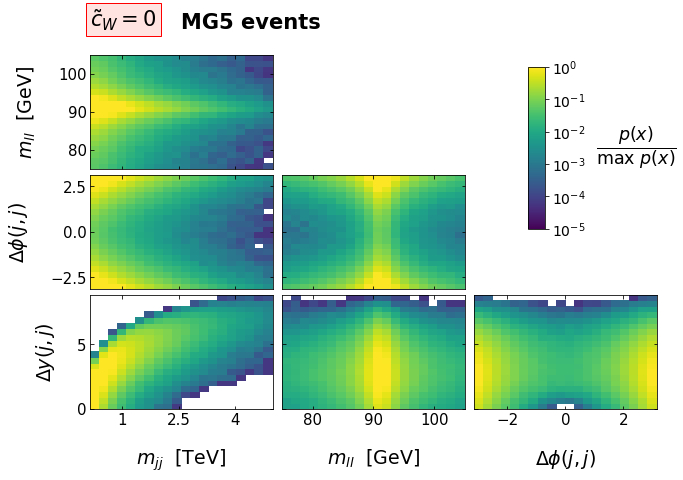

In [60]:

#  Plot MG5 events
datapoints_true, weights_true = data_tables[0].get_observables_and_weights()
plot_data_adv(datapoints_true, weights_true, label="MG5 events", savefig=f"figures/whitening_method/2D_distributions_MG5.pdf")


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


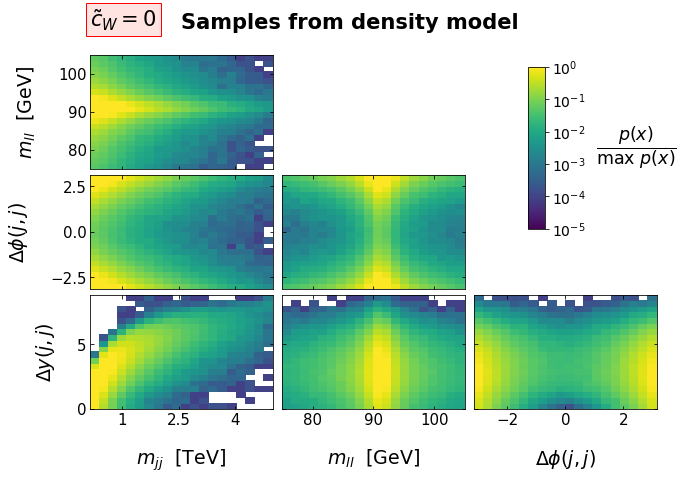

In [61]:

#  Plot generated events
plot_data_adv(fake_datapoints_SM_big, label="Samples from density model", savefig=f"figures/whitening_method/2D_distributions_density_model.pdf")


In [62]:
import tensorflow as tf
print(tf.keras.__version__)

2.4.0
